In [2]:
import numpy as np
from scipy import ndimage as nd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
from typing import List, Union

In [3]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Reduce image size
def reduceRes(image,factor):
    r,c = image.size
    r = int(np.floor(r/factor))
    c = int(np.floor(c/factor))
    new = image.resize((r,c))
    return new


# Box filter for smoothing
def boxFilter(image,rc):
    box = np.ones([rc,rc])/rc**2
    image = nd.convolve(image,box)
    return image


# Pad image with zeros
def pad(image,filter):
    r,c = filter.shape
    factor = int(np.floor(r/2))

    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Normalized Cross Correlation
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    padded = pad(image,filter)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            len_f = np.sqrt(np.sum(f**2))
            if len_f==0:
                norm_f = np.zeros(f.shape)
            else:
                norm_f = f/len_f
            norm_g = filter/np.sqrt(np.sum(filter**2))
            
            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])
            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc


# Harris Corner Detector
def HarrisCorner(image,threshold,width,k):
    
    # Peak finding for nonmax supression
    def peaks(image,window):
        factor = int(np.floor(window.shape[0]/2))
        image = pad(image,window)
        peaks = np.zeros([image.shape[0],image.shape[1]])

        for i in range(1,image.shape[0]-1):
            for j in range(1,image.shape[1]-1):
                window = image[i-1:i+2,j-1:j+2]
                if image[i,j]==np.amax(window):
                    peaks[i,j] = image[i,j]


        # remove padding
        peaks = peaks[factor:-factor,factor:-factor]

        return peaks

    # remove corners that are near the edge
    def nearEdge(corners,width):

        r,c = corners.shape
        edge = int(np.floor((width-1)/2))
        corners[0:edge,:] = 0
        corners[r-edge:r,:] = 0

        corners[:,0:edge] = 0
        corners[:,c-edge:c] = 0

        return corners


    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,np.ones([3,3]))

    # Remove corners near the edge
    R = nearEdge(R,width)

    return R


# Reduce threshold until ~1% of pixels are corners
def reducedHarris(image,width,k,density):

    threshold = 1.0
    ratio = density+1
    while ratio >= density:
        threshold = 0.9*threshold

        corners = HarrisCorner(image,threshold,width,k)
        # Number of corners
        idx = np.where(corners>0)
        idx = np.array(idx).T
        ratio = image.size/idx.shape[0]
    
    print('Corners:',idx.shape[0])

    return corners


# Draw lines between matches
def drawLines(image1,image2,matches,threshold):

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0,x.shape[0]):
        if matches[i,-1] >= threshold:
            plt.plot(y[i,:],x[i,:])
    plt.axis('off')
    
    return


# Normalized Cross Correlation of two equal shaped patches
def patchNCC(f,g):

    len_f = np.sqrt(np.sum(f**2))
    norm_f = f/len_f

    len_g = np.sqrt(np.sum(g**2))
    norm_g = g/len_g

    norm_f = np.reshape(norm_f,[1,f.size])
    norm_g = np.reshape(norm_g,[g.size,1])
    ncc = np.dot(norm_f,norm_g)
            
    return ncc


# Find matches from im1 to im2
def patch2patch(im1,im2,corners1,corners2,width,num_matches):

    # Patch from location
    def getPatch(im,r,c,width):
        left = int( (width-1)/2 )
        right = int( (width-1)/2 + 1 )
        patch = im[r-left:r+right,c-left:c+right]
        return patch

    def cornerCoord(corners):
        idx = np.where(corners>0)
        idx = np.array(idx).T
        return idx

    # Find patch coordinates
    coord1 = cornerCoord(corners1)
    coord2 = cornerCoord(corners2)

    matches = np.zeros([num_matches,5])
    
    i = 0
    while i<num_matches:
        r1 = coord1[i,0]
        c1 = coord1[i,1]
        match = np.array([r1,c1,0,0,0])
  
        # Match the patch to second image
        patch1 = getPatch(im1,r1,c1,width)
    
        for j in range(coord2.shape[0]):
            r2 = coord2[j,0]
            c2 = coord2[j,1]
            patch2 = getPatch(im2,r2,c2,width)

            ncc = patchNCC(patch1,patch2)
            if ncc >= match[4]:
                match = [r1,c1,r2,c2,ncc]

        matches[i,:] = match
        i+=1

    return matches

# Load Image, Reduce Size, Convert to Gray

In [17]:
# Load image1
file = 'DanaHallWay1/DSC_0282.JPG'
file = 'DanaOffice/DSC_0308.JPG'
image = Image.open(file)


# resize = np.max(image.size)/1
resize = 1

# Reduce resolution
image1 = reduceRes(image,resize)
# Convert to grayscale
gray1 = rgb2gray(image1)

# Load image2
file = 'DanaHallWay1/DSC_0283.JPG'
file = 'DanaOffice/DSC_0309.JPG'
image = Image.open(file)
# Reduce resolution
image2 = reduceRes(image,resize)
# Convert to grayscale
gray2 = rgb2gray(image2)

# Add blurring to reduce noise level

In [18]:
# Smooth image
blur = 3
im1 = boxFilter(gray1,blur)
im2 = boxFilter(gray2,blur)

Finding corners...


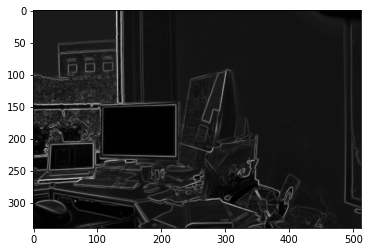

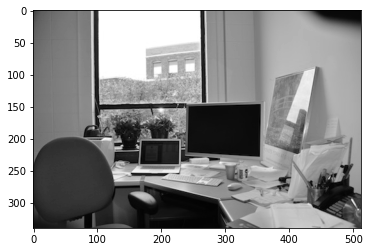

In [22]:
# Find sparse corners
print('Finding corners...')
width = 7
k = 0.04
density = 100
# corners1 = reducedHarris(im1,width,k,density)
# corners2 = reducedHarris(im2,width,k,density)

plt.imshow(gray1,cmap='gray')
# plt.imshow(corners1>0,cmap='gray',alpha=0.5)
Ix = Sobelx(gray1)
Iy = Sobely(gray1)
plt.imshow(np.sqrt(Iy**2 + Ix**2), cmap='gray', alpha=0.9)
plt.show()
plt.imshow(gray2, cmap='gray')
# plt.imshow(corners2>0, cmap='gray', alpha=0.5)

Finding matches...


/tmp/ipykernel_564/2385495382.py:236: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  matches[i,:] = match


1762 matches found.


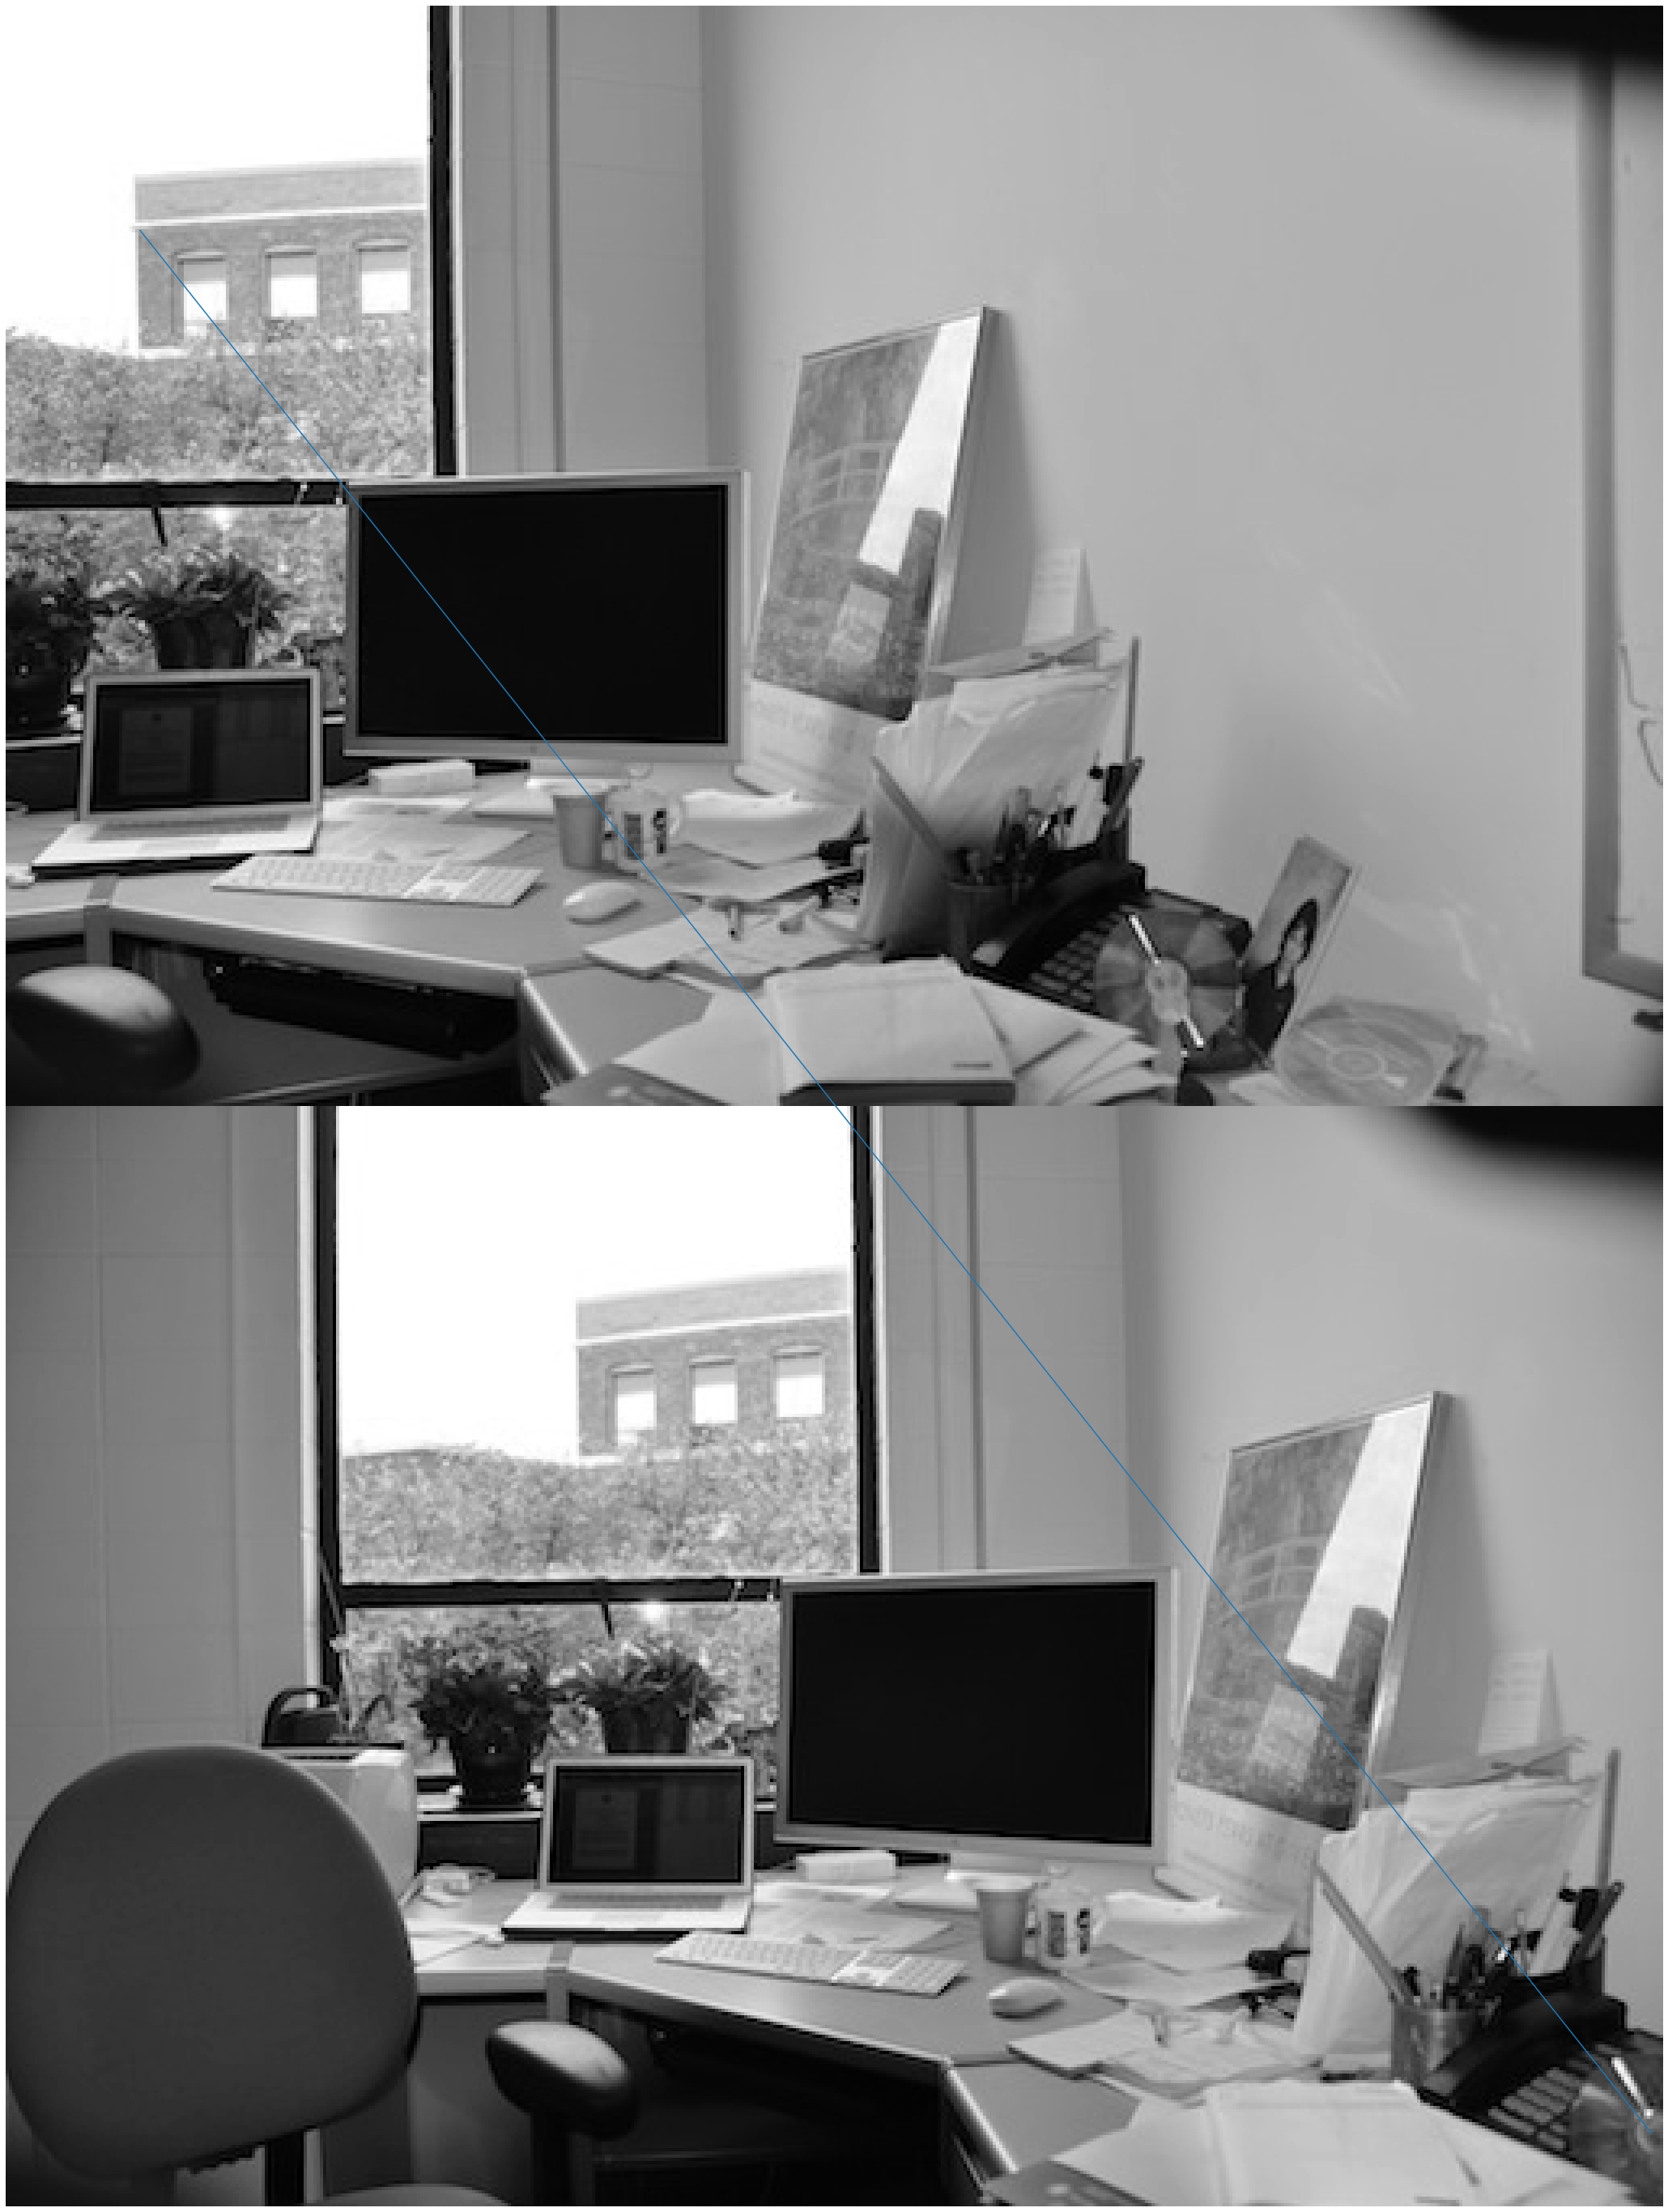

In [563]:
# Find matches
print('Finding matches...')
num_matches = np.sum(corners1>0)
matches = patch2patch(im1,im2,corners1,corners2,7,num_matches)
print(matches.shape[0],'matches found.')
drawLines(gray1,gray2,matches[16:17],0.95)

In [411]:
print(matches)

[[ 4.         94.         44.         53.          0.99421853]
 [ 9.         24.          9.         49.          0.99712646]
 [15.         21.         30.         37.          0.98941555]
 [15.         24.         15.         49.          0.99758945]
 [16.         11.         31.         21.          0.99040171]
 [16.         13.         42.         75.          0.99015937]
 [16.         16.         30.         37.          0.99108174]
 [16.         18.         30.         40.          0.99115394]
 [18.         16.         33.         77.          0.99004989]
 [19.         24.          9.         49.          0.99647086]
 [22.         54.         22.         80.          0.99784975]
 [24.         54.         29.         78.          0.99735659]
 [26.         53.         26.         79.          0.99953832]
 [27.         24.         27.         50.          0.99745256]
 [27.         28.         27.         53.          0.99557921]
 [29.         21.         29.         47.          0.99

In [498]:
def calculate_homography(mappings: List[Union[torch.Tensor, np.ndarray]], 
                         device: Union[torch.types.Device, str]) -> torch.Tensor:
    A = []
    for mapping in mappings:
        if isinstance(mapping, np.ndarray):
            mapping = torch.from_numpy(mapping)
        x = mapping[0].item()
        y = mapping[1].item()
        x_p = mapping[2].item()
        y_p = mapping[3].item()
        A.append([x, y, 1, 0, 0, 0, -x * x_p, -y * x_p, -x_p])
        A.append([0, 0, 0, x, y, 1, -x * y_p, -y * y_p, -y_p])

    A = torch.tensor(A).to(device)
    u, s, v = torch.linalg.svd(A)
    # Extract the minimum eigenvalue and normalize
    h = v[8].reshape(3, 3)
    h = h / h[2, 2].item()
    return h

def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [510]:
h_final = torch.from_numpy(calculateHomography(matches[13:17]))
h_other = calculate_homography(matches[13:17], 'cuda')
print(h_final, h_other)

tensor([[-6.0000e-01, -9.4052e-13,  2.2371e+01],
        [-1.4286e+00,  1.7143e-01,  4.5886e+01],
        [-2.8571e-02, -3.3230e-14,  1.0000e+00]], dtype=torch.float64) tensor([[-5.9854e-01, -5.7440e-04,  2.2358e+01],
        [-1.4272e+00,  1.7068e-01,  4.5890e+01],
        [-2.8538e-02, -1.8853e-05,  1.0000e+00]], device='cuda:0')


In [503]:
p_1 = torch.tensor([matches[12][0], matches[12][1], 1])
p_2 = torch.tensor([matches[12][2], matches[12][3], 1])
print(p_1, p_2)

tensor([26., 53.,  1.], dtype=torch.float64) tensor([26., 79.,  1.], dtype=torch.float64)


In [504]:
a = torch.matmul(h_final, p_1)
print(a / a[2].item())

tensor([26.3333, 69.3333,  1.0000], dtype=torch.float64)


In [416]:
def geometricDistance(correspondence, h):
    p1 = np.transpose(np.matrix([correspondence[0], correspondence[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[2], correspondence[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def ransac(corr, thresh):
    import random
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculate_homography(randomFour, 'cpu')
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers


In [444]:
final_H, max_inliers = ransac(matches, 1000)
print(final_H)

Corr size:  67  NumInliers:  5 Max inliers:  5
Corr size:  67  NumInliers:  9 Max inliers:  9
Corr size:  67  NumInliers:  40 Max inliers:  40
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  4 Max inliers:  45
Corr size:  67  NumInliers:  9 Max inliers:  45
Corr size:  67  NumInliers:  26 Max inliers:  45
Corr size:  67  NumInliers:  12 Max inliers:  45
Corr size:  67  NumInliers:  22 Max inliers:  45
Corr size:  67  NumInliers:  45 Max inliers:  45
Corr size:  67  NumInliers:  21 Max inliers:  45
Corr size:  67  NumInliers:  10 Max inliers:  45
Corr size:  67  NumInliers:  6 Max inliers:  45
Corr size:  67  NumInliers:  15 Max inliers:  45
Corr size:  67  NumInliers:  26 Max inliers:  45
Corr size:  67  NumInliers:  8 Max inliers:  45
Corr size:  67  NumInliers:  16 Max inliers:  45
Corr size:  67  NumInliers:  10 Max inliers:  45
Corr size:  67  NumInliers:  7 Max inliers:  45
Corr size:  67  NumInliers:  7

Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  16 Max inliers:  46
Corr size:  67  NumInliers:  17 Max inliers:  46
Corr size:  67  NumInliers:  9 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  12 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  9 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  38 Max inliers:  46
Corr size:  67  NumInliers:  10 Max inliers:  46
Corr size:  67  NumInliers:  13 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  23 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  40 M

Corr size:  67  NumInliers:  27 Max inliers:  46
Corr size:  67  NumInliers:  16 Max inliers:  46
Corr size:  67  NumInliers:  20 Max inliers:  46
Corr size:  67  NumInliers:  3 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  40 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  10 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  10 Max inliers:  46
Corr size:  67  NumInliers:  32 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  2 Max inliers:  46
Corr size:  67  NumInliers:  3 Max inliers:  46
Corr size:  67  NumInliers:  45 Max inliers:  46
Corr size:  67  NumInliers:  17 Max inliers:  46
Corr size:  67  NumInliers:  4 

Corr size:  67  NumInliers:  35 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  3 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  45 Max inliers:  46
Corr size:  67  NumInliers:  2 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  45 Max inliers:  46
Corr size:  67  NumInliers:  3 Max inliers:  46
Corr size:  67  NumInliers:  11 Max inliers:  46
Corr size:  67  NumInliers:  11 Max inliers:  46
Corr size:  67  NumInliers:  12 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  1 Max inliers:  46
Corr size:  67  NumInliers:  3 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  45 Max inliers:  46
Corr size:  67  NumInliers:  37 Max inliers:  46
Corr size:  67  NumInliers:  17 

Corr size:  67  NumInliers:  9 Max inliers:  46
Corr size:  67  NumInliers:  13 Max inliers:  46
Corr size:  67  NumInliers:  20 Max inliers:  46
Corr size:  67  NumInliers:  9 Max inliers:  46
Corr size:  67  NumInliers:  42 Max inliers:  46
Corr size:  67  NumInliers:  14 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  16 Max inliers:  46
Corr size:  67  NumInliers:  45 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  9 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  45 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  45 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  8 M

Corr size:  67  NumInliers:  18 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  6 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  21 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  19 Max inliers:  46
Corr size:  67  NumInliers:  7 Max inliers:  46
Corr size:  67  NumInliers:  10 Max inliers:  46
Corr size:  67  NumInliers:  5 Max inliers:  46
Corr size:  67  NumInliers:  3 Max inliers:  46
Corr size:  67  NumInliers:  11 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  18 Max inliers:  46
Corr size:  67  NumInliers:  9 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  8 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  4 Max inliers:  46
Corr size:  67  NumInliers:  14 Max inliers:  46
Corr size:  67  NumInliers:  6 Ma

In [564]:
pts = np.array(matches)[:, :-1]
print(pts.shape)
print(srce_pts.shape)
srce_pts = pts[:, :2].reshape(-1, 1, 2)
print(dest_pts.shape)
dest_pts = pts[:, 2:].reshape(-1, 1, 2)

homographyMat_1, mask = cv2.findHomography(srce_pts, dest_pts, cv2.RANSAC, 1.0)
print(homographyMat, homographyMat_1)

(1762, 4)
(67, 1, 2)
(67, 1, 2)
[[-6.00000000e-01 -1.07007014e-15  2.23714286e+01]
 [-1.42857143e+00  1.71428571e-01  4.58857143e+01]
 [-2.85714286e-02 -3.69264086e-17  1.00000000e+00]] [[ 9.31750705e-01 -7.86281247e-02  1.15589704e+01]
 [ 4.76110937e-02  7.62363480e-01  1.38550135e+02]
 [ 9.07697355e-05 -5.33147489e-04  1.00000000e+00]]


In [438]:
import cv2
import matplotlib
matplotlib.rcParams['figure.figsize'] = [50, 50]

tensor([[-6.0000e-01, -9.4052e-13,  2.2371e+01],
        [-1.4286e+00,  1.7143e-01,  4.5886e+01],
        [-2.8571e-02, -3.3230e-14,  1.0000e+00]], dtype=torch.float64)
-19 534 0 488
[19, 0]


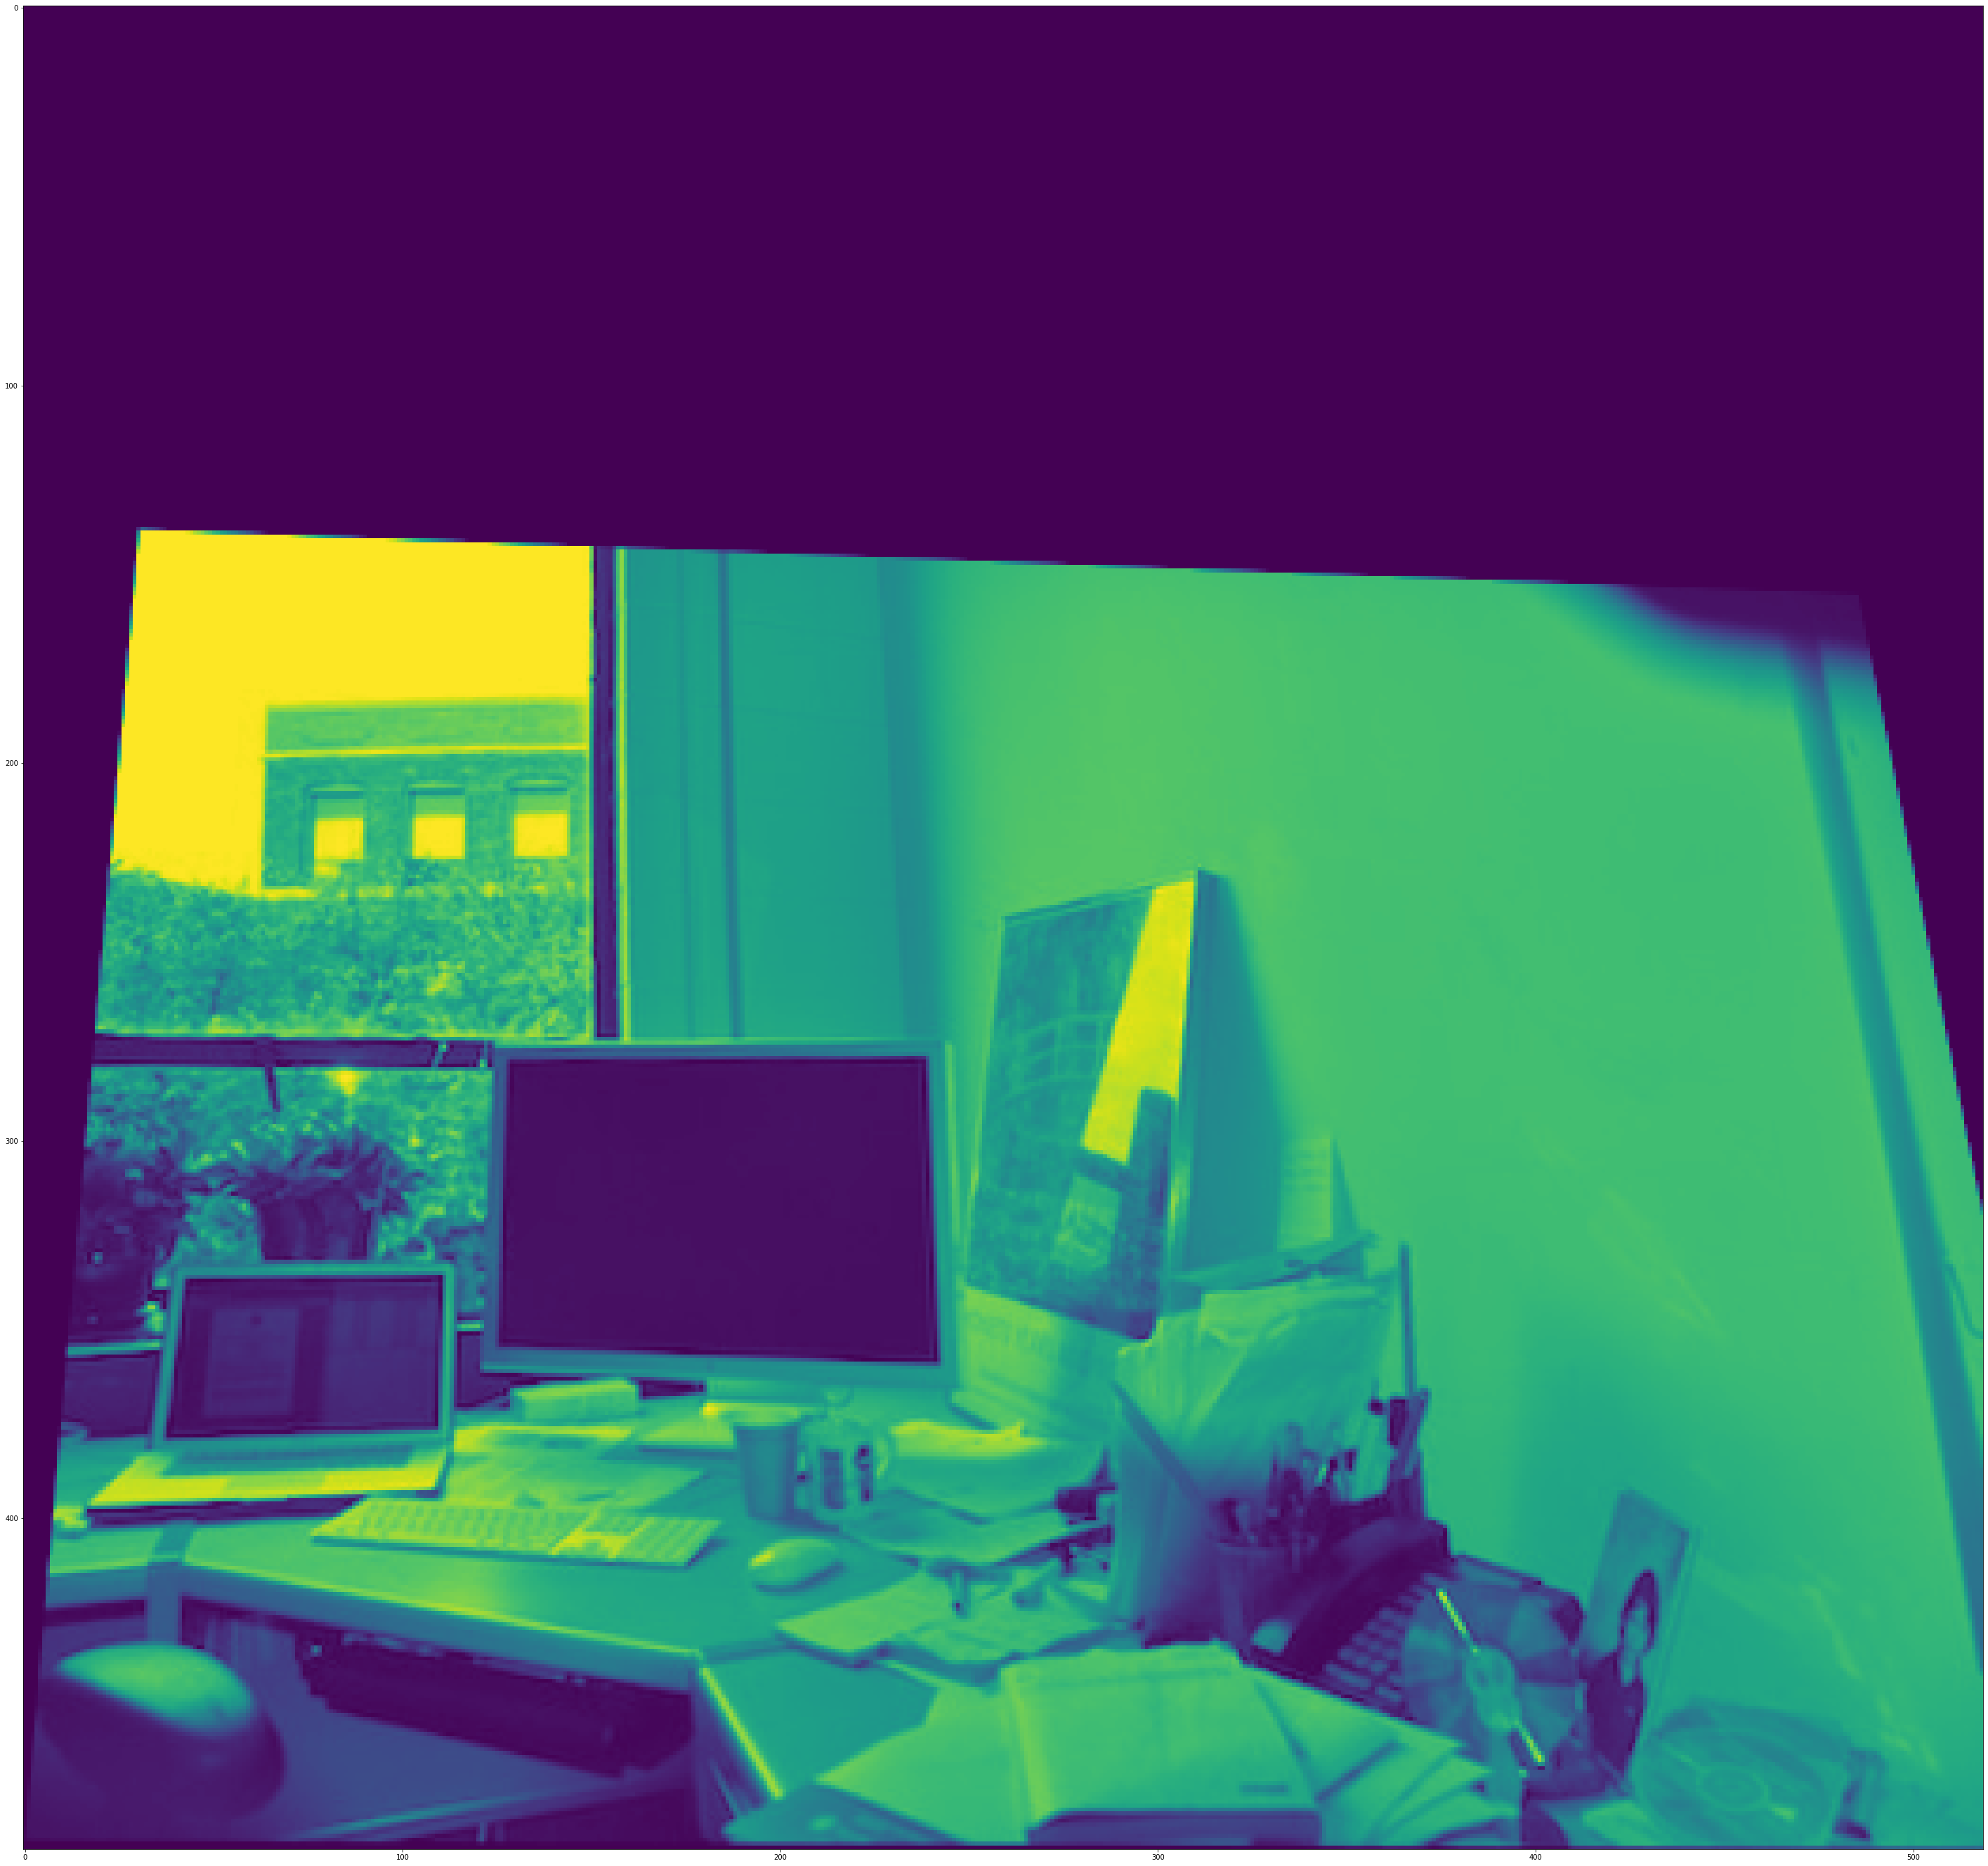

(340, 512)

In [583]:
print(h_final)

h1, w1 = gray1.shape[:2]
h2, w2 = gray2.shape[:2]
pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
pts2_ = cv2.perspectiveTransform(pts1, homographyMat_1)
pts = np.concatenate((pts1, pts2_), axis=0)

#Finding the minimum and maximum coordinates
[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)


print(xmin, xmax, ymin, ymax)
t = [-xmin, -ymin]
print(t)
#Translating
Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])



# Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
result = cv2.warpPerspective(gray1, Ht.dot(homographyMat_1),  (500-xmin, ymax-ymin))
# h1, w1 = gray2.shape
# result[t[1]:h1+t[1], t[0]:w1+t[0]] = gray2
# result[:66, :100] = gray2
plt.imshow(result)
# plt.show()
# plt.imshow(gray1)
# plt.show()
# plt.imshow(gray2)
plt.show()
gray1.shape

In [324]:
# Load image1
file = 'DanaOffice/DSC_0308.JPG'
image = Image.open(file)


# resize = np.max(image.size)/100

# Reduce resolution
# image1 = reduceRes(image,resize)
# Convert to grayscale
gray1 = rgb2gray(image)
print(gray1.shape)

# Load image2
file = 'DanaOffice/DSC_0309.JPG'
image = Image.open(file)
# Reduce resolution
# image2 = reduceRes(image,resize)
# Convert to grayscale
gray2 = rgb2gray(image)

(340, 512)
